In [21]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.fftpack as fft
from tqdm import tqdm

In [80]:
def load_data(data_dir, filename):
    # assign columns label
    columns = ['unix_time', 'n_samples', 'time_period', 'sampling_rate', 'sensor_data']
    df = pd.read_csv(os.path.join(data_dir, filename), 
                     header=None, sep=';', names=columns, nrows=1000)
    
    print('Data have been loaded as dataframe!')
    return df

data_dir = os.getcwd() + '/DataSet' 
filename = 'project_pump.csv'
df_pump = load_data(data_dir, filename)

Data have been loaded as dataframe!


In [34]:
df_pump

,n_samples,time_period,sampling_rate,data_id,record_time
0,16384,340,48188.235294,Id0001,2019-05-03 13:51:43.326399088
1,16384,340,48188.235294,Id0002,2019-05-03 13:51:43.710902929
2,16384,341,48046.920821,Id0003,2019-05-03 13:51:44.096714020
3,16384,340,48188.235294,Id0004,2019-05-03 13:51:44.478333950
4,16384,340,48188.235294,Id0005,2019-05-03 13:51:44.870509863
5,16384,341,48046.920821,Id0006,2019-05-03 13:51:45.245586634
6,16384,340,48188.235294,Id0007,2019-05-03 13:51:45.616322994
7,16384,340,48188.235294,Id0008,2019-05-03 13:51:45.989959955
8,16384,341,48046.920821,Id0009,2019-05-03 13:51:46.366917133
9,16384,340,48188.235294,Id0010,2019-05-03 13:51:46.750856161


In [81]:
def refactor_data(df):
    # refactor data format 
    print('Refactoring sensor data fomat ...')
    data = df['sensor_data'].values
    data = [item[:-1] for item in tqdm(data)]
    # unit to Volt
    data = [float(val[1:])/1000 for item in tqdm(data) for val in item.split(',')]
    data = np.array(data).reshape(len(df), -1)
    # generate data identification number
    data_id = ['Id' + str(i).zfill(4) for i in tqdm(range(1, len(df)+1))]
    df['data_id'] = data_id
    # generate time serie
    time = np.arange(0, 341, 341/16384)
    # collect sensor data to dataframe
    data_dict = {data_id[i]:data[i] for i in range(len(df))}
    df_data = pd.DataFrame(data_dict)
    df_data['time'] = time
    df_data = df_data.set_index('time')
    # convert unix_time to actual datetime
    df['record_time'] = pd.to_datetime(df['unix_time'], unit='s')
    df = df.drop(columns=['unix_time', 'sensor_data'])
    
    return df, df_data

df_pump, df_data = refactor_data(df_pump)

  0%|          | 0/882 [00:00<?, ?it/s]

Refactoring sensor data fomat ...


100%|██████████| 882/882 [00:00<00:00, 249856.55it/s]


In [83]:
df_data.head()

,Id0001,Id0002,Id0003,Id0004,Id0005,Id0006,Id0007,Id0008,Id0009,Id0010,...,Id0873,Id0874,Id0875,Id0876,Id0877,Id0878,Id0879,Id0880,Id0881,Id0882
time,,,,,,,,,,,,,,,,,,,,,
0.000000,1.618378,1.618327,1.619788,1.619536,1.619133,1.618277,1.619536,1.619183,1.619637,1.617824,...,1.585547,1.639677,1.610925,1.618277,1.624974,1.619788,1.593855,1.641943,1.614098,1.595970
0.020813,1.620291,1.620039,1.620493,1.619586,1.619888,1.620543,1.619485,1.620039,1.626031,1.619637,...,1.590028,1.639627,1.614601,1.620140,1.626485,1.623917,1.595869,1.643504,1.610925,1.598639
0.041626,1.620190,1.620291,1.620039,1.619939,1.619687,1.620493,1.619687,1.622003,1.620442,1.620039,...,1.596021,1.638469,1.612083,1.620392,1.625024,1.622658,1.596675,1.648288,1.609515,1.595920
0.062439,1.619939,1.618831,1.620190,1.624521,1.619888,1.621147,1.619788,1.619385,1.620744,1.620341,...,1.590431,1.638268,1.613544,1.619536,1.626787,1.623715,1.598085,1.640231,1.613997,1.599344
0.083252,1.620392,1.620341,1.619888,1.619888,1.620392,1.620392,1.620241,1.620593,1.620341,1.620190,...,1.587511,1.640382,1.613493,1.618579,1.625075,1.625427,1.595517,1.646576,1.610522,1.602969


In [107]:
N = len(df_data)
sample_space = 341e-3/16384 # sec
# Hz
x = np.fft.fftfreq(N, sample_space)[1:N//2]
# fft
df_data_fft = pd.DataFrame()
df_data_fft['freq'] = x
df_data_fft = df_data_fft.set_index('freq')
for idx in tqdm(df_data.columns):
    # positive only
    f = np.fft.fft(df_data[idx])
    fft_values = np.abs(f[1:N//2])
    df_data_fft[idx] = fft_values

100%|██████████| 882/882 [00:01<00:00, 445.07it/s]


array([2.93255132e+00, 5.86510264e+00, 8.79765396e+00, ...,
       2.40146628e+04, 2.40175953e+04, 2.40205279e+04])

In [176]:
# Clustering with K-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=100).fit(df_data_fft.T)
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [122]:
centers = kmeans.cluster_centers_

In [178]:
df_pump['cluster_label'] = kmeans.labels_

In [179]:
df_pump[df_pump['cluster_label']==1]

,n_samples,time_period,sampling_rate,data_id,record_time,cluster_label
184,16384,340,48188.235294,Id0185,2019-05-03 13:52:56.138085842,1
334,16384,340,48188.235294,Id0335,2019-05-03 13:53:55.796028614,1
341,16384,340,48188.235294,Id0342,2019-05-03 13:53:58.580206156,1
345,16384,340,48188.235294,Id0346,2019-05-03 13:54:00.168756008,1
374,16384,341,48046.920821,Id0375,2019-05-03 13:54:11.719614029,1
380,16384,340,48188.235294,Id0381,2019-05-03 13:54:14.087651014,1
385,16384,341,48046.920821,Id0386,2019-05-03 13:54:16.080901861,1
397,16384,341,48046.920821,Id0398,2019-05-03 13:54:20.852773190,1
398,16384,340,48188.235294,Id0399,2019-05-03 13:54:21.252151966,1
405,16384,340,48188.235294,Id0406,2019-05-03 13:54:24.033093929,1


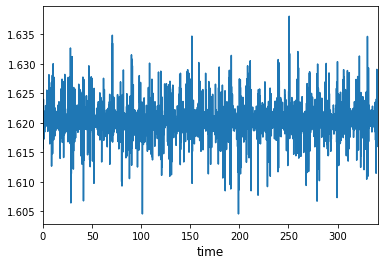

In [185]:
df_data['Id0181'].plot()